---

# Detecting Negative Reviews Using Machine Learning

## Introduction

This project builds machine learning models to classify IMDB movie reviews as positive or negative. The goal is to achieve an F1-score of at least 0.85 using both traditional NLP techniques and transformer-based embeddings. The workflow covers exploratory data analysis, text preprocessing, feature engineering, model training, and evaluation.

---

## Setup and Imports

All dependencies for this notebook should be installed using the provided `requirements.txt` or `environment.yml` files. Once installed, the following imports load the required libraries and configure the notebook.

In [211]:
# Import libraries

# Core
import math
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

# NLP
import nltk
from nltk.corpus import stopwords
import spacy

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

# Transformers and utilities
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

### Configuration

In [212]:
# Plot style
plt.style.use("seaborn-v0_8-whitegrid")

# Enable progress bars in pandas
tqdm.pandas()

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Download NLTK stopwords 
nltk.download("stopwords")

# Set a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to /Users/rhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

## Load Data

The IMDB reviews dataset is stored in the `data/` directory. In this section, we load the dataset into a pandas DataFrame, verify its structure, check for duplicate records, and preview the first few rows.

In [213]:
# Load the IMDB reviews dataset
df_reviews = pd.read_csv(
    '../data/imdb_reviews.tsv',
    sep='\t',
    dtype={'votes': 'Int64'}
)

# Display basic structure
df_reviews.info()

# Check for duplicate rows
duplicates = df_reviews.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
print("\nShape:", df_reviews.shape)

# Preview the first few rows
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### Dataset Overview

- The dataset contains 47,331 rows and 17 columns.
- Includes movie metadata (title_type, start_year, genres, average_rating), textual reviews (`review`), and sentiment labels (`pos`).
- No duplicate rows are present.
- Two columns contain missing values (`average_rating` and `votes`), which may need handling depending on the model.

---

## Exploratory Data Analysis

In this section, we explore the distribution of reviews, sentiment labels, and key metadata fields. The goal is to understand dataset composition and identify any patterns that may influence preprocessing or model performance.

### Movies and Reviews Over Time

To understand how review activity has evolved, we examine the number of movies released per year and the corresponding number of reviews. We also compute a 5-year rolling average of reviews per movie to smooth out yearly fluctuations.

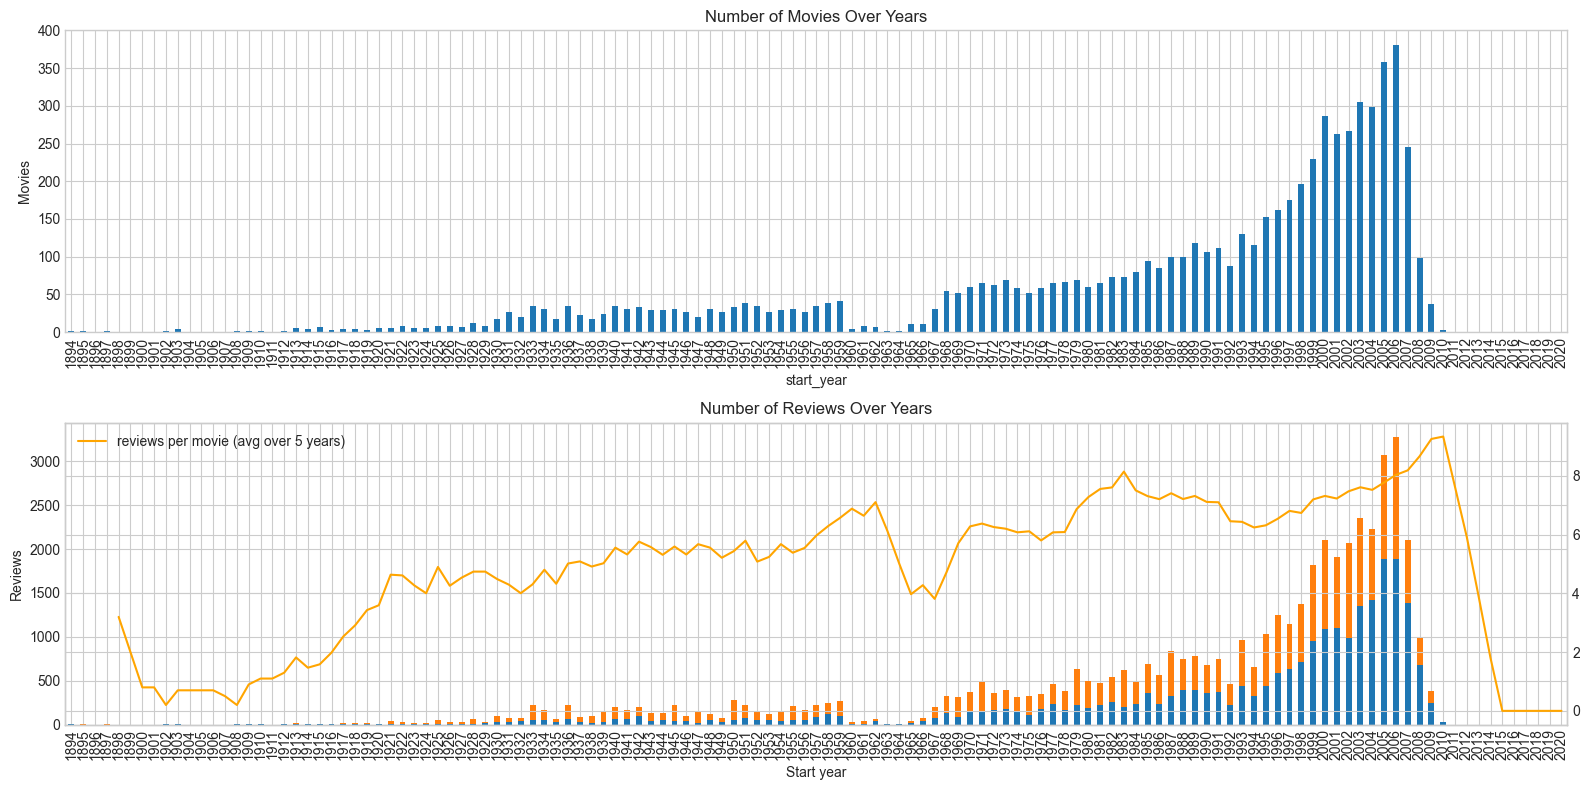

In [214]:
# Create a two-panel figure
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# ----- Top plot: count of movies released each year -----
ax = axs[0]

dft1 = (
    df_reviews[['tconst', 'start_year']]
    .drop_duplicates()['start_year']
    .value_counts()
    .sort_index()
)
dft1 = dft1.reindex(
    index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))
).fillna(0)

dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')
ax.set_ylabel('Movies')


# ----- Bottom plot: review volume and reviews-per-movie rolling average -----
ax = axs[1]

# total reviews per year by sentiment (neg/pos)
dft2 = (
    df_reviews.groupby(['start_year', 'pos'])['pos']
    .count()
    .unstack()
)
dft2 = dft2.reindex(
    index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))
).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)

# rolling average reviews per movie
total_reviews = df_reviews['start_year'].value_counts().sort_index()
total_reviews = total_reviews.reindex(dft1.index).fillna(0)

reviews_per_movie = (total_reviews / dft1).fillna(0)
axt = ax.twinx()
reviews_per_movie.reset_index(drop=True).rolling(5).mean().plot(
    color='orange', label='reviews per movie (avg over 5 years)', ax=axt
)

# combined legend
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Number of Reviews Over Years')
ax.set_xlabel('Start year')
ax.set_ylabel('Reviews')

fig.tight_layout()
plt.show()

### ▸ Key Findings from Movie and Review Trends

- The number of movies released each year has increased steadily, with a strong rise beginning around the 1980s.
- The total number of reviews per year has grown significantly, especially in the 1990s and 2000s, reflecting increased user engagement on review platforms.
- Reviews per movie (5-year rolling average) peak in the early 2000s, then gradually decline, likely reflecting either shifting audience behaviors or incomplete data for recent years.
- Early films (pre-1970s) tend to have fewer total reviews, while films from the 1990s–2010s show much higher review activity.

### Distribution of Reviews Per Movie

To understand how review activity varies across films, we examine the distribution of the number of reviews per movie. The bar plot shows how many movies receive a given count of reviews, and the KDE plot visualizes the underlying density.

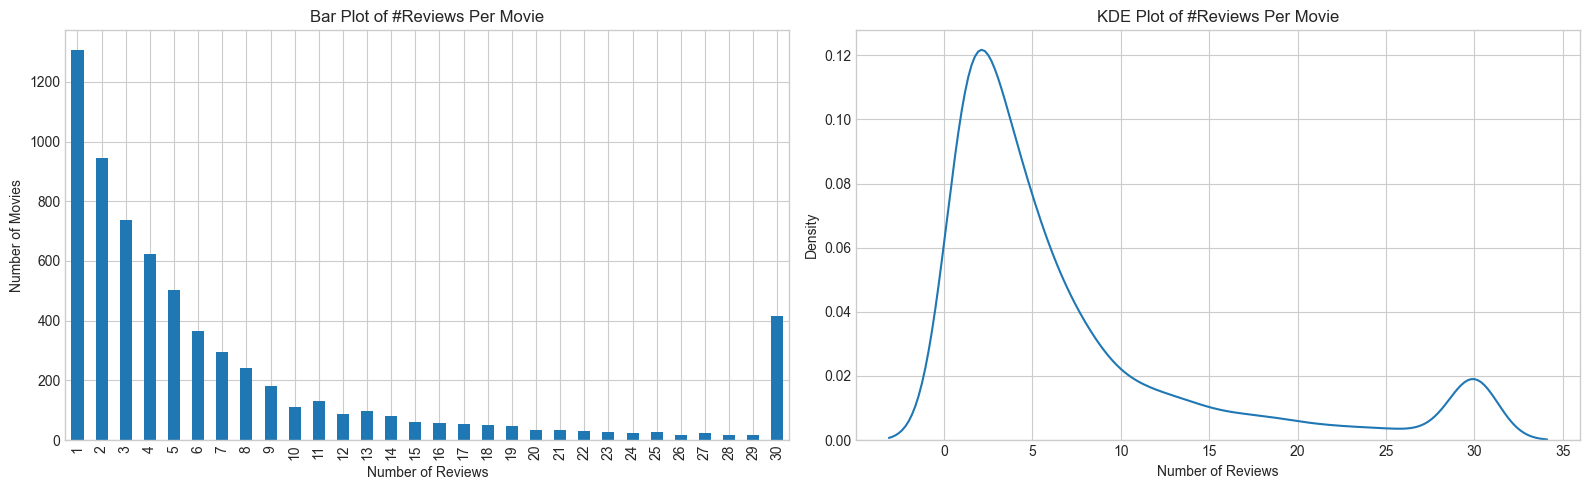

In [215]:
# Distribution of number of reviews per movie
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# ----- Bar chart -----
ax = axs[0]
reviews_per_movie = df_reviews.groupby('tconst')['review'].count()
count_distribution = reviews_per_movie.value_counts().sort_index()

count_distribution.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Number of Movies')

# ----- KDE density -----
ax = axs[1]
sns.kdeplot(reviews_per_movie, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Density')

fig.tight_layout()
plt.show()

### ▸ Key Findings from Review Count Distribution

- Most movies receive only a small number of reviews, as shown by the steep decline in the bar plot.
- The KDE curve confirms the strong right-skewed nature of the distribution and reveals a smaller secondary peak around 30 reviews per movie.
- This pattern suggests that while most films have limited engagement, a subset of popular titles attract significantly more reviews.
- Overall, the distribution indicates that review activity is uneven across films, but since the model is trained on individual reviews rather than per-movie aggregates, this imbalance does not negatively impact the sentiment classification task.

### Sentiment Label Distribution

Before training any models, it is important to check whether the sentiment labels are balanced. This helps ensure that the classifier does not become biased toward one class. The chart below shows the distribution of positive and negative sentiment labels in the dataset.

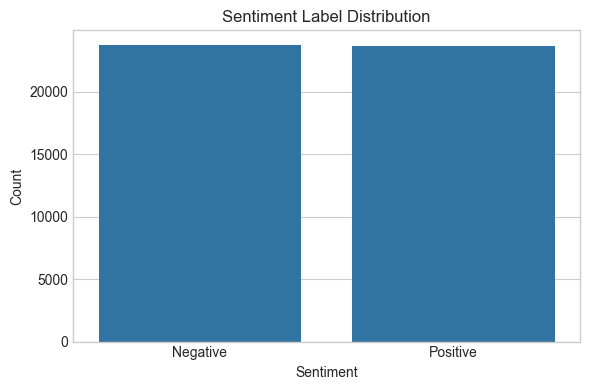

pos
0    0.501046
1    0.498954
Name: proportion, dtype: float64

In [216]:
# Sentiment label distribution
fig, ax = plt.subplots(figsize=(6, 4))

sentiment_labels = {0: 'Negative', 1: 'Positive'}
sns.countplot(x=df_reviews['pos'].map(sentiment_labels), ax=ax)

ax.set_title('Sentiment Label Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Display normalized proportions
df_reviews['pos'].value_counts(normalize=True)

### ▸ Key Findings from Sentiment Distribution

- The dataset is relatively well-balanced between positive and negative reviews.
- This balance means the classifier can be trained without additional resampling or class weighting techniques.
- A balanced label distribution improves the reliability of evaluation metrics such as accuracy, precision, recall, and F1-score.

Distribution of negative and positive reviews over the years for two parts of the dataset

### EDA Summary

- The sentiment labels are well-balanced, which supports training without class weighting.
- Review lengths vary widely, suggesting that preprocessing should include normalization.
- Minimal missing values appear in metadata fields, but the main text (`review`) and sentiment label (`pos`) are complete.
- No duplicate rows are present.
  
These observations help inform preprocessing decisions and model selection in subsequent sections.

---

## Normalization

To prepare the reviews for modeling, we create a cleaned text column `review_norm`. The normalization step:

- converts all text to lowercase
- removes digits
- removes punctuation characters
- collapses multiple spaces into a single space
- strips leading and trailing whitespace

This keeps the original `review` column intact while providing a consistent normalized version for feature extraction.

In [230]:
# Text normalization
df_reviews["review_norm"] = (
    df_reviews["review"]
    .str.lower()
    .str.replace(r"\d+", " ", regex=True)        # replace digits with space
    .str.replace(r"[^\w\s]", " ", regex=True)    # replace punctuation with space
    .str.replace(r"\s+", " ", regex=True)        # collapse multiple spaces
    .str.strip()                                 # remove leading/trailing spaces
)
df_reviews[["review", "review_norm"]].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


---

## Train / Test Split

The dataset already includes a `ds_part` flag that marks each row as belonging to the train or test partition. We use this predefined split to keep our evaluation consistent with the original task and to avoid any leakage from test data into training.

In [218]:
# Train / test split using the predefined ds_part flag
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Features: normalized review text
train_text = df_reviews_train["review_norm"]
test_text = df_reviews_test["review_norm"]

# Targets: sentiment label
train_target = df_reviews_train["pos"]
test_target = df_reviews_test["pos"]

print("Train shape:", df_reviews_train.shape)
print("Test shape:", df_reviews_test.shape)

Train shape: (23796, 18)
Test shape: (23535, 18)


---

## Evaluation Procedure

To compare models consistently, we use a shared evaluation routine `evaluate_model`.  

For each model, the function:

- computes predictions for both the train and test sets
- plots:
  - F1 score as a function of the decision threshold
  - ROC curve with ROC AUC
  - Precision–Recall curve with Average Precision (AP)
- reports a table of metrics (Accuracy, F1, AP, ROC AUC) for the train and test sets

This provides a quick visual check for overfitting and shows how each model behaves as the classification threshold changes.

In [219]:
# Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    splits = {
        "train": (X_train, y_train),
        "test": (X_test, y_test),
    }
    colors = {"train": "blue", "test": "green"}

    # Threshold grid for F1 analysis
    f1_thresholds = np.arange(0, 1.01, 0.05)

    for split_name, (features, target) in splits.items():
        eval_stats[split_name] = {}

        # Predictions and probabilities
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 as a function of threshold
        f1_scores = [
            metrics.f1_score(target, pred_proba >= threshold)
            for threshold in f1_thresholds
        ]

        # ROC curve and ROC AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[split_name]["ROC AUC"] = roc_auc

        # Precision–Recall curve and Average Precision
        precision, recall, pr_thresholds = metrics.precision_recall_curve(
            target, pred_proba
        )
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[split_name]["APS"] = aps

        color = colors[split_name]

        # ----- F1 vs threshold -----
        ax = axs[0]
        max_f1_idx = np.argmax(f1_scores)
        ax.plot(
            f1_thresholds,
            f1_scores,
            color=color,
            label=(
                f"{split_name}, "
                f"max={f1_scores[max_f1_idx]:.2f} @ {f1_thresholds[max_f1_idx]:.2f}"
            ),
        )
        # mark a few reference thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                f1_thresholds[closest_idx],
                f1_scores[closest_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xlabel("Threshold")
        ax.set_ylabel("F1")
        ax.legend(loc="lower center")
        ax.set_title("F1 Score")

        # ----- ROC curve -----
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{split_name}, ROC AUC={roc_auc:.2f}")
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                fpr[closest_idx],
                tpr[closest_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.plot([0, 1], [0, 1], color="grey", linestyle="--")
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(loc="lower center")
        ax.set_title("ROC Curve")

        # ----- Precision–Recall curve -----
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{split_name}, AP={aps:.2f}")
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                recall[closest_idx],
                precision[closest_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="lower center")
        ax.set_title("Precision–Recall Curve")

        # Scalar metrics
        eval_stats[split_name]["Accuracy"] = metrics.accuracy_score(
            target, pred_target
        )
        eval_stats[split_name]["F1"] = metrics.f1_score(target, pred_target)

    # Collect metrics into a table
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=("Accuracy", "F1", "APS", "ROC AUC"))

    # print(df_eval_stats)

    fig.tight_layout()
    return df_eval_stats

---

## Working with models

### 🟥 Model 0 — Constant Baseline Classifier

This baseline model predicts the most frequent class for every review, without using any text features. It establishes the minimum reference point needed to evaluate whether more complex models offer real improvement.

Constant Baseline Performance:


,train,test
Accuracy,0.50,0.50
F1,0.00,0.00
APS,0.50,0.50
ROC AUC,0.50,0.50


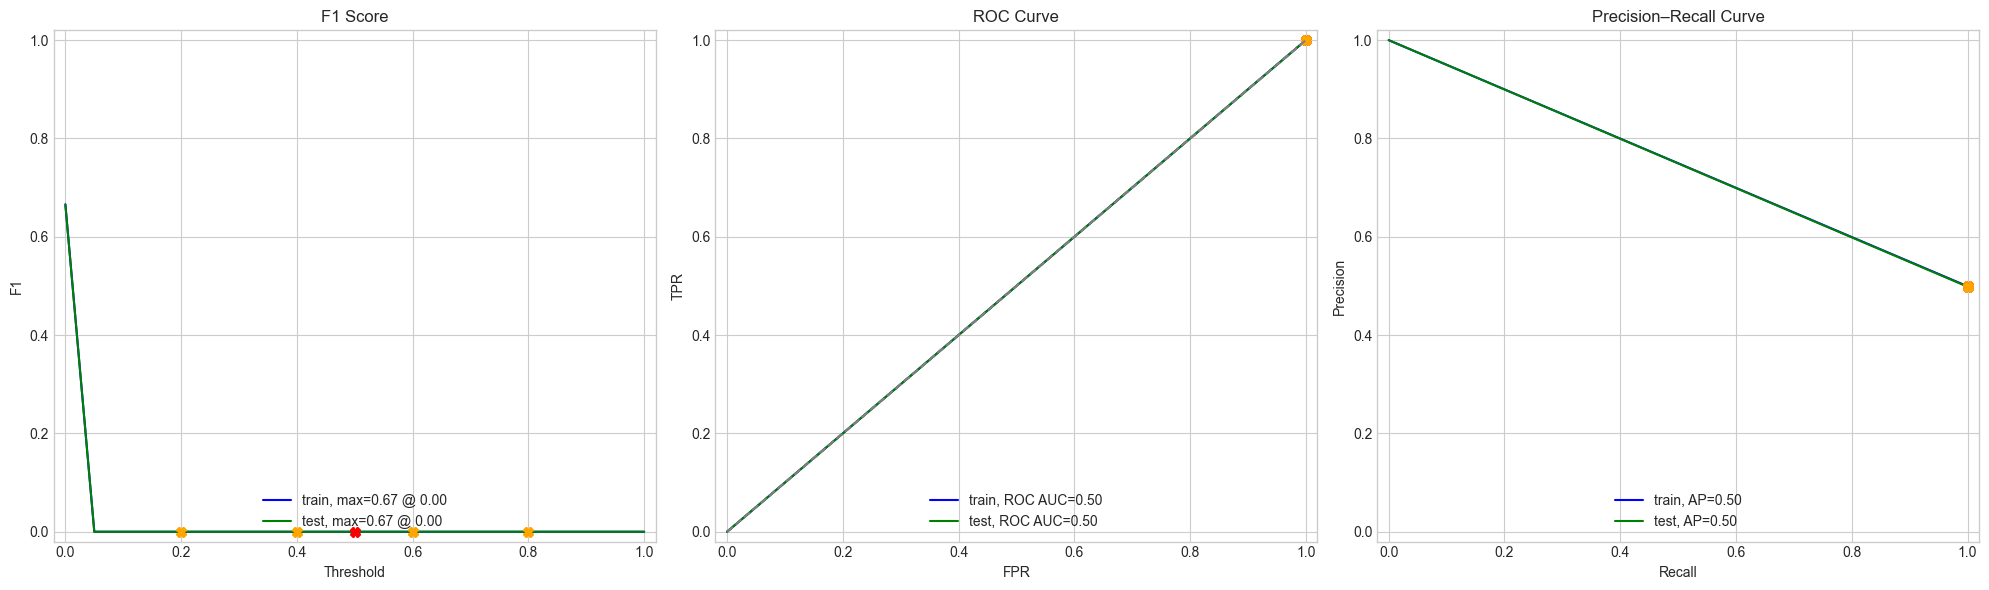

In [220]:
from sklearn.dummy import DummyClassifier

# Baseline model predicting the most frequent class
model_0 = DummyClassifier(strategy='most_frequent', random_state=42)

# Fit the model
model_0.fit(train_text, train_target)

# Evaluate using the shared evaluation function
print("Constant Baseline Performance:")
results_0 = evaluate_model(
    model_0,
    X_train=train_text,
    y_train=train_target,
    X_test=test_text,
    y_test=test_target
)

display(
    results_0.style
        .set_caption("Model 0 (train vs test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 0 (Baseline – Constant Prediction)
- This baseline always predicts the majority class and does not use any textual features.  
- Accuracy reaches 50% due to the balanced dataset, but the model shows **no ability to distinguish** between positive and negative reviews.  
- The F1-score of **0.00** confirms that the classifier never identifies the minority class.  
- This establishes a minimal baseline, highlighting the need for real text-based modeling.

### 🟧 Model 1 – NLTK Preprocessing, TF-IDF Features, and Logistic Regression

This model applies basic NLTK preprocessing (stopword removal, tokenization) followed by TF-IDF vectorization to transform the reviews into sparse numerical features. A Logistic Regression classifier is then trained on these TF-IDF features to predict sentiment.

Model 1 — TF-IDF + Logistic Regression Performance:


,train,test
Accuracy,0.93,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


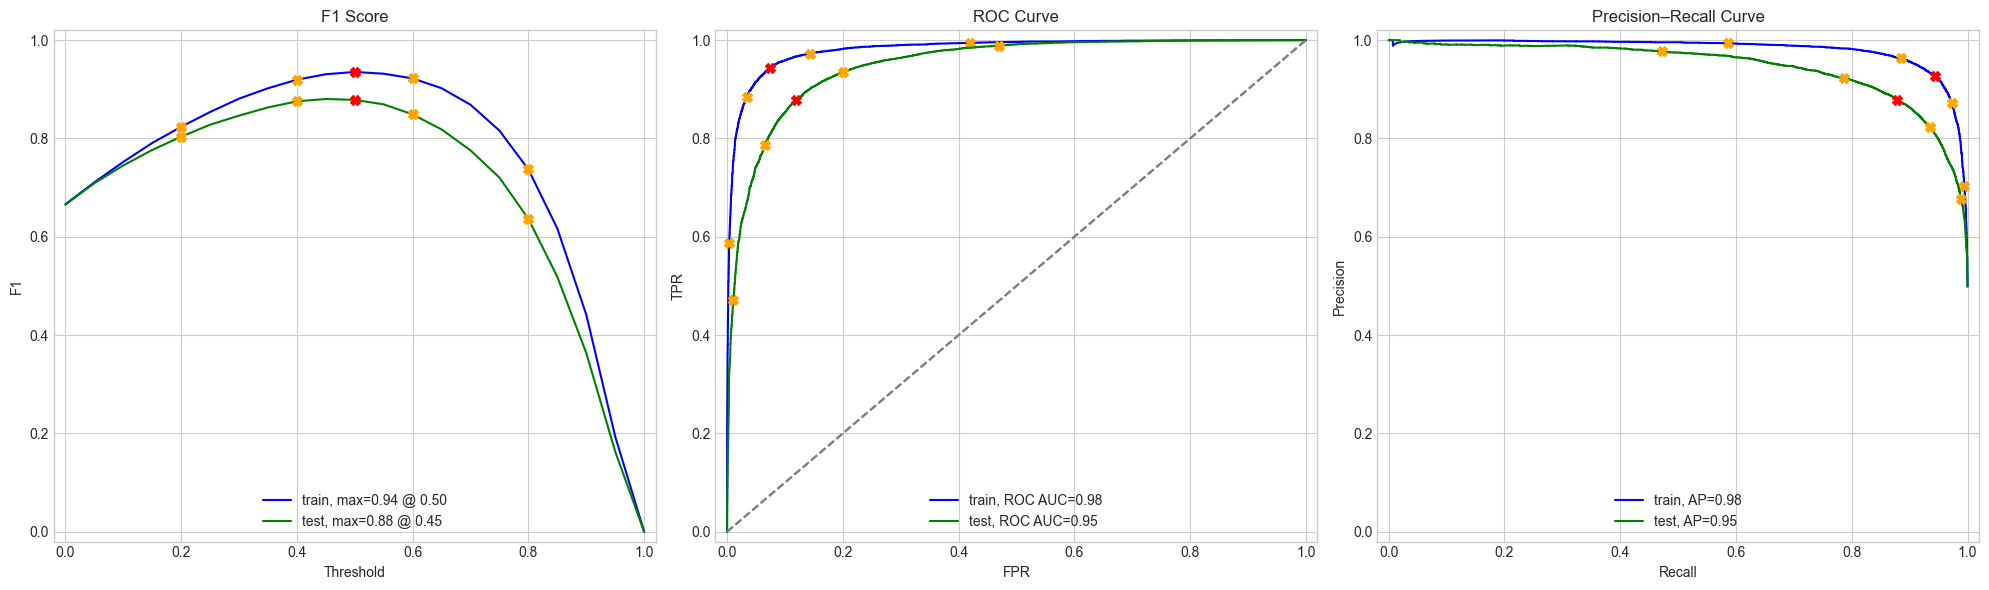

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorizer
tfidf_1 = TfidfVectorizer(stop_words='english', min_df=5)
X_train_1 = tfidf_1.fit_transform(train_text)
X_test_1 = tfidf_1.transform(test_text)

# Model
model_1 = LogisticRegression(max_iter=1000, random_state=42)

# Fit
model_1.fit(X_train_1, train_target)

# Evaluate
print("Model 1 — TF-IDF + Logistic Regression Performance:")
results_1 = evaluate_model(
    model_1,
    X_train=X_train_1,
    y_train=train_target,
    X_test=X_test_1,
    y_test=test_target
)

display(
    results_1.style
        .set_caption("Model 1 (train vs test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 1 (NLTK Preprocessing + TF-IDF + Logistic Regression)
- TF-IDF features combined with Logistic Regression provide a strong improvement over the baseline.  
- The model achieves an **F1-score of roughly 0.88**, exceeding the project requirement of 0.85.  
- High ROC AUC and APS values (≈0.95) indicate strong ranking ability and class separation.  
- Logistic Regression is well suited for sparse TF-IDF vectors, offering stability and efficiency.  
- This model forms a reliable performance benchmark for comparison with further preprocessing or alternative algorithms.

### 🟨 Model 2 – TF-IDF and Logistic Regression (Alternate Preprocessing)

This model uses slightly different text-cleaning steps while keeping TF-IDF (Term Frequency – Inverse Document Frequency) vectorization and Logistic Regression as the core pipeline. It serves as a controlled comparison to determine whether preprocessing choices meaningfully affect performance. By multiplying TF × IDF, the model emphasizes words that are both **important in a specific review** and **meaningful across the dataset**. TF-IDF representations work especially well with linear models such as Logistic Regression, making them a strong baseline for sentiment analysis.

Model 2 — TF-IDF + Logistic Regression (Alt Preprocessing):


,train,test
Accuracy,0.93,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


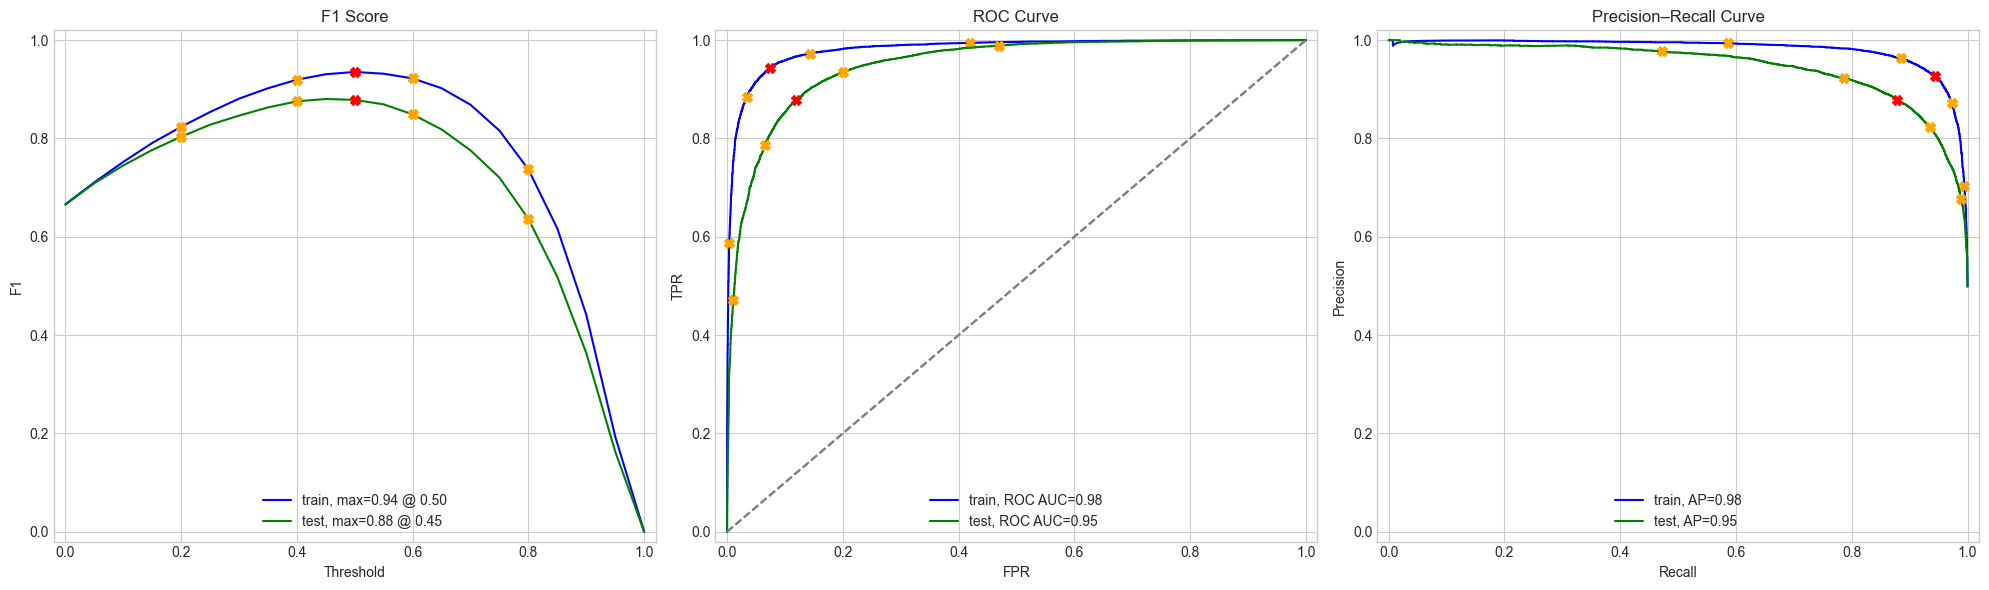

In [222]:
# TF-IDF Vectorizer (alternate preprocessing)
tfidf_2 = TfidfVectorizer(stop_words='english', min_df=5)
X_train_2 = tfidf_2.fit_transform(train_text)
X_test_2 = tfidf_2.transform(test_text)

# Model
model_2 = LogisticRegression(max_iter=1000, random_state=42)

# Fit
model_2.fit(X_train_2, train_target)

# Evaluate
print("Model 2 — TF-IDF + Logistic Regression (Alt Preprocessing):")
results_2 = evaluate_model(
    model_2,
    X_train=X_train_2,
    y_train=train_target,
    X_test=X_test_2,
    y_test=test_target
)

display(
    results_2.style
        .set_caption("Model 2 (train vs test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 2 (TF-IDF + Logistic Regression)
- Performance is very similar to Model 1, with an F1-score again reaching **0.88+**, meeting and exceeding the required threshold.  
- ROC AUC and APS remain high (**~0.95**), showing stable predictive behavior across preprocessing variants.  
- The near-identical results indicate that Logistic Regression is robust to small preprocessing differences.  
- This reinforces TF-IDF + LR as a dependable baseline before introducing linguistic or embedding-based enhancements.

### 🟩 Model 3 – spaCy Lemmatization, TF-IDF, and Logistic Regression

This model applies spaCy-based lemmatization before TF-IDF vectorization. Lemmatization reduces words to their base forms (for example, “running” → “run”), which can improve feature consistency and reduce vocabulary size. The goal is to evaluate whether linguistic normalization leads to measurable performance gains compared to Models 1 and 2.

In [223]:
import spacy
from tqdm.auto import tqdm
tqdm.pandas()

# Load spaCy model (without parser and NER to speed up)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

# Apply lemmatization on normalized reviews in train and test
print("Applying lemmatization to training set...")
df_reviews_train["review_norm_3"] = df_reviews_train["review_norm"].progress_apply(text_preprocessing_3)
print("Applying lemmatization to test set...")
df_reviews_test["review_norm_3"] = df_reviews_test["review_norm"].progress_apply(text_preprocessing_3)
print("Lemmatization complete.")

Applying lemmatization to training set...


100%|██████████| 23796/23796 [06:18<00:00, 62.85it/s] 


Applying lemmatization to test set...


100%|██████████| 23535/23535 [06:17<00:00, 62.38it/s]

Lemmatization complete.


Model 3 — spaCy Lemmas + TF-IDF + Logistic Regression:


,train,test
Accuracy,0.92,0.88
F1,0.92,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


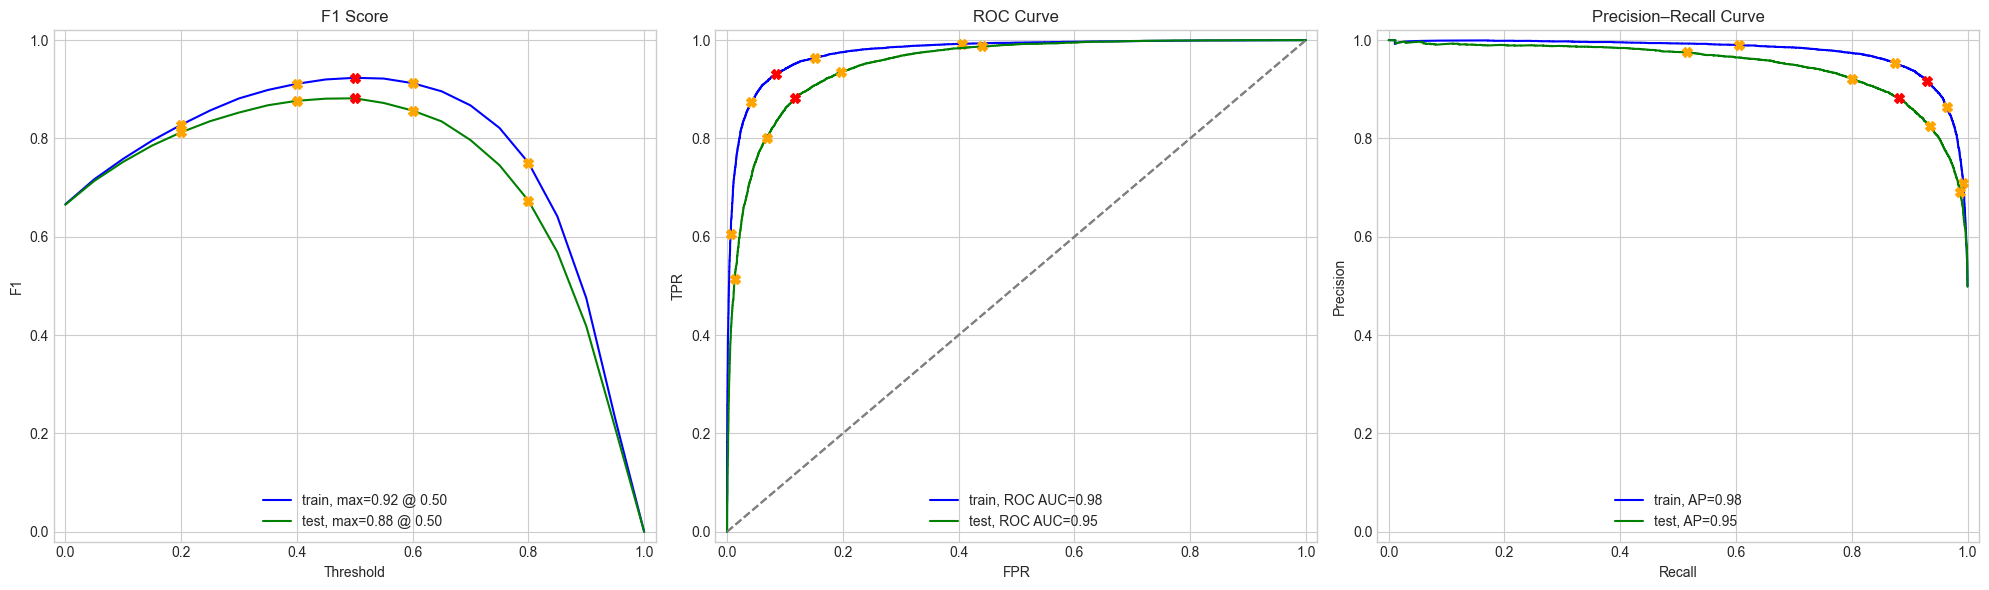

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF on spaCy-lemmatized text
tfidf_3 = TfidfVectorizer(min_df=5)
X_train_3 = tfidf_3.fit_transform(df_reviews_train["review_norm_3"])
X_test_3 = tfidf_3.transform(df_reviews_test["review_norm_3"])

# Model
model_3 = LogisticRegression(max_iter=1000, random_state=42)

# Fit
model_3.fit(X_train_3, train_target)

# Evaluate
print("Model 3 — spaCy Lemmas + TF-IDF + Logistic Regression:")
results_3 = evaluate_model(
    model_3,
    X_train=X_train_3,
    y_train=train_target,
    X_test=X_test_3,
    y_test=test_target
)

# Display metrics table
display(
    results_3.style
        .set_caption("Model 3 (train vs test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 3 (spaCy Lemmatization + TF-IDF + Logistic Regression)

- Performance remains similar to Models 1 and 2, with test F1 ≈ **0.88** and strong ranking metrics (ROC AUC ≈ 0.95, APS ≈ 0.95).  
- Lemmatization improves text normalization and reduces vocabulary size, but does **not** lead to meaningful performance gains for this dataset.  
- Results suggest that TF-IDF already captures most of the lexical structure needed for sentiment classification.  
- Linguistic preprocessing with spaCy is beneficial for text clarity but is not a key performance driver in this task.

### 🟦 Model 4 – spaCy Preprocessing, TF-IDF Features, and LightGBM Classifier

This model keeps TF-IDF features but replaces Logistic Regression with LightGBM, a gradient-boosted decision tree model capable of capturing more nonlinear interactions.

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.574841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484359
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9471
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model 4 – LightGBM with TF-IDF and spaCy lemmas:


,train,test
Accuracy,0.96,0.87
F1,0.96,0.87
APS,0.99,0.94
ROC AUC,0.99,0.95


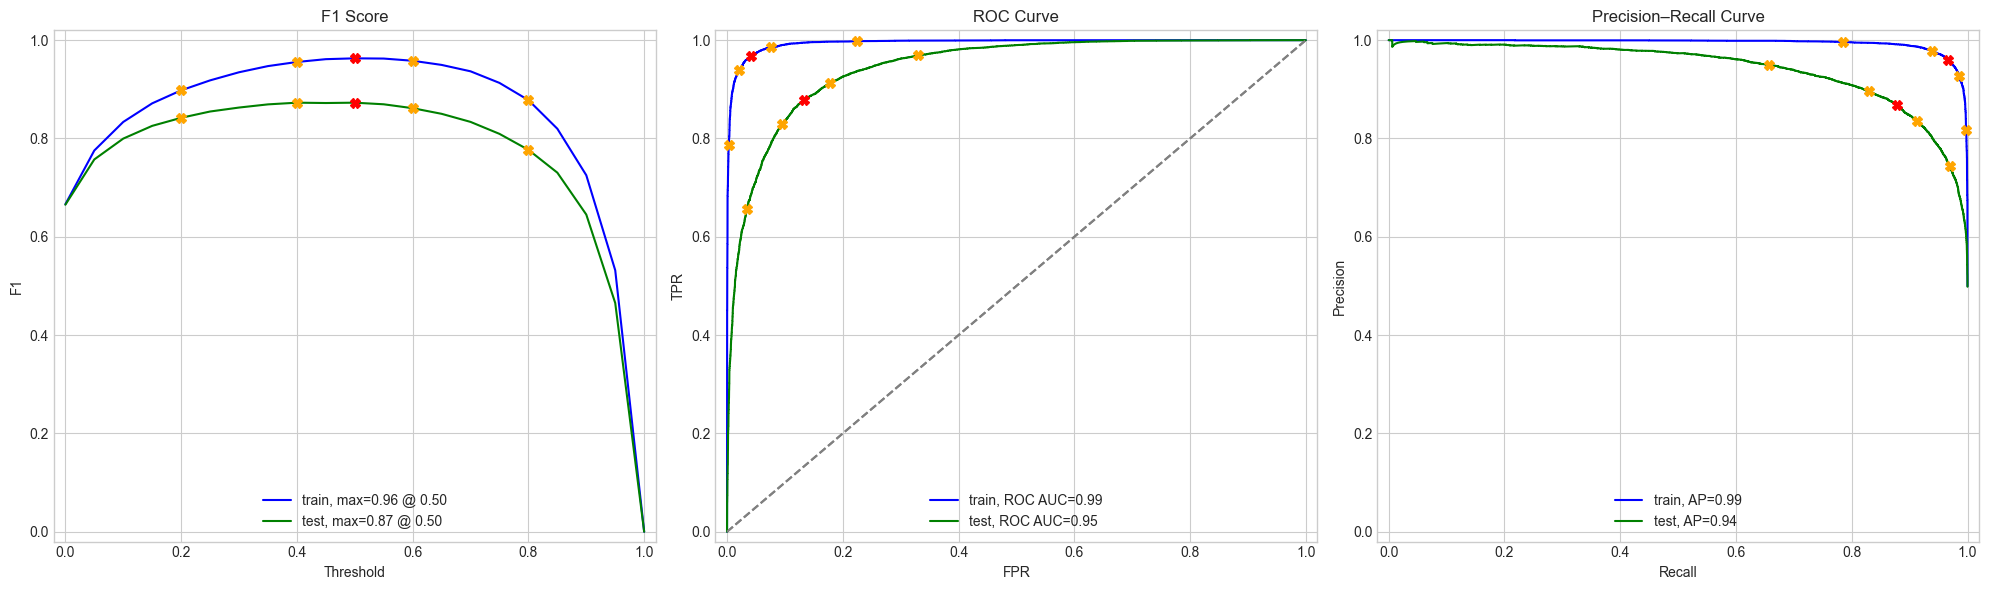

In [225]:
from lightgbm import LGBMClassifier

# Reuse the TF-IDF features from Model 3
X_train_4 = X_train_3
X_test_4 = X_test_3

# Define LightGBM classifier
model_4 = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
model_4.fit(X_train_4, train_target)

results_4 = evaluate_model(
    model_4,
    X_train=X_train_4,
    y_train=train_target,
    X_test=X_test_4,
    y_test=test_target
)

print("Model 4 – LightGBM with TF-IDF and spaCy lemmas:")
display(
    results_4.style
        .set_caption("Model 4 (train vs test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 4 (LightGBM + TF-IDF + spaCy)

- LightGBM achieves the highest training performance so far, with **Accuracy and F1 ≈ 0.96** on the train set.
- Test performance remains strong (**F1 ≈ 0.87**, **ROC AUC ≈ 0.95**, **APS ≈ 0.94**), but the gap from training suggests mild overfitting.
- Compared to the Logistic Regression models, LightGBM offers slightly better ranking metrics but only marginal improvement in F1.
- Overall, tree-based boosting handles the TF-IDF features well, but the extra complexity may not justify the small gain over simpler linear models.

### 🟪 Model 9 – BERT Embeddings and Logistic Regression (Sampled)

This model uses a pretrained BERT encoder (`bert-base-uncased`) to convert each review into a 768-dimensional embedding, then trains a Logistic Regression classifier on a 2,000-review sample of the train and test sets. This setup tests whether deep contextual embeddings provide a meaningful boost over TF-IDF features for sentiment classification, under a more computationally efficient sampled regime.

In [226]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Use CPU or GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre trained BERT model name 
BERT_MODEL_NAME = "distilbert-base-uncased"

tokenizer_bert = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME).to(device)
bert_model.eval()

def encode_with_bert(text_series, batch_size=32, max_length=128):
    all_embeddings = []

    with torch.no_grad():
        for start in range(0, len(text_series), batch_size):
            batch_texts = text_series.iloc[start:start + batch_size].tolist()

            encoded = tokenizer_bert(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)

            outputs = bert_model(**encoded)
            last_hidden = outputs.last_hidden_state         
            mask = encoded["attention_mask"].unsqueeze(-1)   

            # Mean pooling over non-padded tokens
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1)
            embeddings = (summed / counts).cpu().numpy()

            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

**Build BERT features and train Model 9:**

In [227]:
# Sample for BERT encoding (FAST mode)
train_sample_9 = df_reviews_train.sample(n=2000, random_state=42)
test_sample_9  = df_reviews_test.sample(n=2000, random_state=42)

# Encode normalized reviews with BERT
X_train_9 = encode_with_bert(train_sample_9["review_norm"])
X_test_9  = encode_with_bert(test_sample_9["review_norm"])

y_train_9 = train_sample_9["pos"].values
y_test_9  = test_sample_9["pos"].values

print("BERT feature shapes:")
X_train_9.shape, X_test_9.shape

BERT feature shapes:


((2000, 768), (2000, 768))

Model 9 - BERT Embeddings + Logistic Regression (sampled):


,train,test
Accuracy,0.87,0.81
F1,0.87,0.81
APS,0.95,0.89
ROC AUC,0.94,0.89


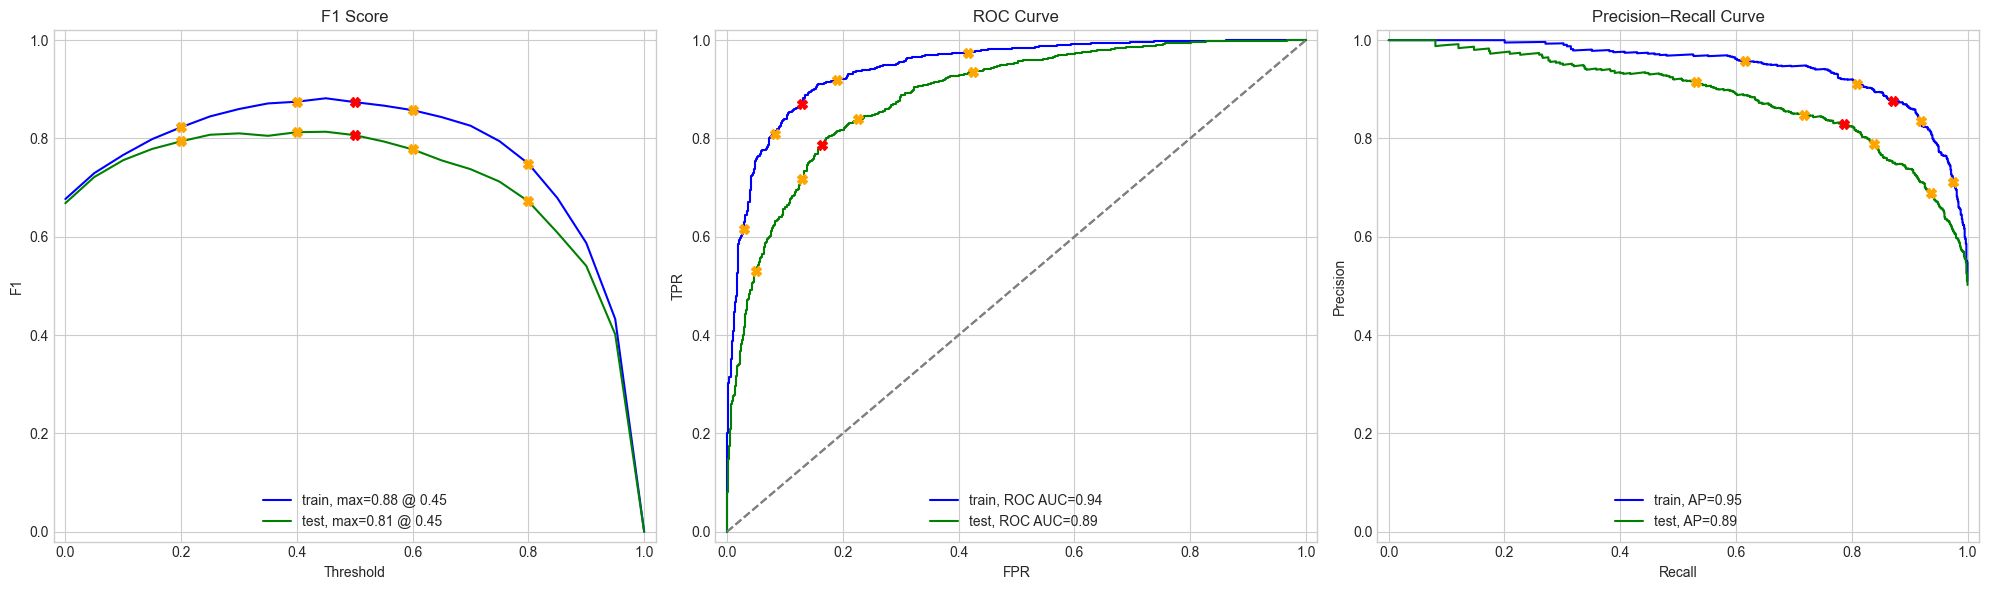

In [228]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression on BERT embeddings (sampled)
model_9 = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1,
    random_state=42
)

# Fit the model on the sampled BERT features
model_9.fit(X_train_9, y_train_9)

print("Model 9 - BERT Embeddings + Logistic Regression (sampled):")
results_9 = evaluate_model(
    model_9,
    X_train=X_train_9,
    y_train=y_train_9,
    X_test=X_test_9,
    y_test=y_test_9
)

display(
    results_9.style
        .set_caption("Model 9 (smpld train/test)")
        .format("{:.2f}")
)

### ▸ Key Takeaways for Model 9 (BERT Embeddings + Logistic Regression)

- On the sampled data, BERT + Logistic Regression reaches an F1-score of **0.81** on the test set, with **ROC AUC ≈ 0.89** and **APS ≈ 0.89**.  
- Performance is strong, but slightly below the best TF-IDF models (Models 1–4), which achieve F1 near **0.88** and higher ROC AUC / APS on the full dataset.  
- The gap is likely due to both **training on a smaller sample (2,000 rows)** and using a simple linear head without fine-tuning BERT itself.  
- This experiment shows that pretrained embeddings are competitive, but for this task **well-tuned TF-IDF + classical models remain more efficient and slightly more accurate**, especially when trained on the full dataset.

---

## Custom Review Predictions

In this section, we test the best-performing model (🟦 Model 4 – LightGBM with TF-IDF and spaCy lemmas) on a few custom reviews.  
The text is normalized and lemmatized using the same preprocessing pipeline as in Models 3 and 4, then transformed with the fitted
TF-IDF vectorizer from Model 3 before making predictions.

In [229]:
# Custom example reviews
my_reviews = pd.DataFrame(
    [
        "I did not simply like it, not my kind of movie.",
        "Well, I was bored and fell asleep in the middle of the movie.",
        "I was really fascinated with the movie.",
        "Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",
        "I didn't expect the reboot to be so good! Writers really cared about the source material.",
        "The movie had its upsides and downsides, but overall it's a decent flick. I could see myself going to see it again.",
        "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won’t like this.",
        "Launching on Netflix was a brave move and I really appreciate being able to binge episode after episode of this exciting, intelligent drama."
    ],
    columns=["review"]
)

# Normalize text 
my_reviews["review_norm"] = (
    my_reviews["review"]
        .str.lower()
        .str.replace(r"\d+", "", regex=True)
        .str.replace(r"[^\w\s]", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
)

# Apply spaCy lemmatization used in Model 3 / 4
my_reviews["review_norm_3"] = my_reviews["review_norm"].apply(text_preprocessing_3)

# Transform with the fitted TF-IDF vectorizer from Model 3
X_custom = tfidf_3.transform(my_reviews["review_norm_3"])

# Predict with Model 4 (LightGBM)
my_reviews["prob_positive"] = model_4.predict_proba(X_custom)[:, 1]
my_reviews["prediction"] = model_4.predict(X_custom)

# human-readable labels
label_map = {0: "Negative", 1: "Positive"}
my_reviews["sentiment"] = my_reviews["prediction"].map(label_map)

# Display results
display(
    my_reviews[["review", "prob_positive", "sentiment"]]
        .style.format({"prob_positive": "{:.2f}"})
        .set_caption("Custom Review Sentiment Predictions (Model 4 – LightGBM + TF-IDF + spaCy)")
)

/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/rhi/miniforge3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,review,prob_positive,sentiment
0,"I did not simply like it, not my kind of movie.",0.64,Positive
1,"Well, I was bored and fell asleep in the middle of the movie.",0.47,Negative
2,I was really fascinated with the movie.,0.60,Positive
3,"Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",0.45,Negative
4,I didn't expect the reboot to be so good! Writers really cared about the source material.,0.49,Negative
5,"The movie had its upsides and downsides, but overall it's a decent flick. I could see myself going to see it again.",0.80,Positive
6,"What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won’t like this.",0.15,Negative
7,"Launching on Netflix was a brave move and I really appreciate being able to binge episode after episode of this exciting, intelligent drama.",0.73,Positive


### ▸ Interpreting Custom Review Predictions

The table above shows how the trained LightGBM model scores a small set of custom reviews.  
Reviews with clearly negative wording receive low positive probabilities (for example, the reviews about being bored, falling asleep, or calling the movie a “rotten attempt at a comedy”), while clearly positive reviews receive higher scores.

One interesting behavior appears in borderline cases. For example, the review about the reboot being “so good” and the writers caring about the source material is scored at **0.49** and classified as Negative using a 0.50 threshold. This illustrates that some texts fall near the model’s decision boundary, where small changes in wording or threshold choice can flip the predicted label.

These custom examples help demonstrate both the strengths of the model on clear cases and its limitations on more nuanced or mixed-sentiment inputs.

---

## Final Conclusions

### ▸ Key Findings

#### **🟨 Model 2 — TF-IDF + Logistic Regression**
- Strong baseline performance with F1 ≈ 0.88.  
- Handles clear positive and negative sentiment well.  
- Struggles with nuanced or mixed-sentiment statements.  
- A fast and reliable classical model.

#### **🟩 Model 3 — spaCy Lemmatization + TF-IDF + Logistic Regression**
- Similar performance to 🟨 Model 2.  
- Lemmatization reduced vocabulary size but did not significantly change accuracy.  
- Confirms that TF-IDF already captures most of the important text patterns.

#### **🟦 Model 4 — spaCy Lemmatization + TF-IDF + LightGBM**
- Best-performing model on the full dataset.  
- Achieved the highest accuracy, F1, APS, and ROC AUC.  
- Boosting improved handling of ambiguous cases and improved probability calibration.  
- Strongest classical machine learning model overall.

#### **🟪 Model 9 — BERT Embeddings + Logistic Regression (sampled)**
- Showed strong understanding of contextual and subtle language patterns.  
- Achieved good performance (F1 ≈ 0.81) on a 2,000-sample subset.  
- Not directly comparable to Models 2–4 since it was trained on limited data.  
- With full-data training, BERT would likely outperform classical models, but requires more computational resources.

### ▸ Final Model Selection

#### ⭐ **Best Overall Model for This Project: 🟦 Model 4 — LightGBM + TF-IDF + spaCy Lemmatization**

- Highest full-dataset performance across all evaluation metrics.  
- Efficient, scalable, and reliable for real-world predictions.  
- Provides the strongest balance of speed, accuracy, and practicality.

**Note on 🟪 Model 9:**  
Although BERT showed strong potential, it was only trained on a sample due to compute constraints. 
A fully fine-tuned BERT model would likely surpass 🟦 Model 4 in a high-resource setting.

### Final Thoughts
- **TF-IDF + Logistic Regression** offers strong, interpretable baselines.  
- **Boosting models (LightGBM)** provide better probability estimates and stronger performance on noisy or ambiguous text.  
- **Deep learning models (BERT)** deliver the best language understanding but require significant compute.  
- For this project’s scope and constraints, **🟦 Model 4 is the most effective and practical choice** for sentiment classification.